In [2]:
!pip install yfinance==0.2.28

In [2]:
import numpy as np 
import pandas as pd
import os
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import yfinance as yf
from scipy.optimize import LinearConstraint, Bounds, NonlinearConstraint
from scipy.stats import norm, t
import scipy.stats as st

In [194]:
stocks = ['AAPL']
weights = np.ones(len(stocks))*(1/len(stocks))
trading_days = 252.
end = '2023-8-30'
start = '2022-4-30'

[*********************100%%**********************]  1 of 1 completed


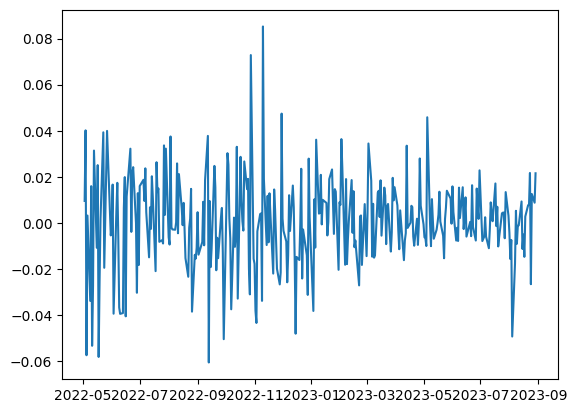

In [195]:
s = [stock for stock in stocks]
data_test = yf.download(s, start=start, end=end)
pct_change_test = np.log(data_test['Close'].pct_change().dropna()+1)
plt.plot(pct_change_test)


plt.show()

[*********************100%%**********************]  1 of 1 completed


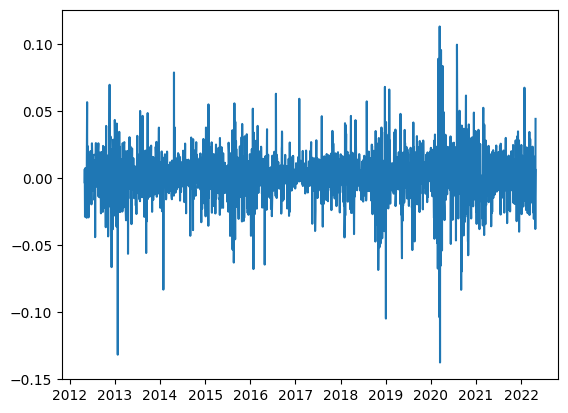

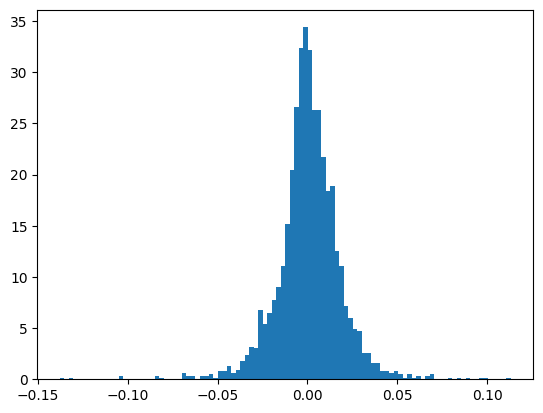

In [196]:
start = '2012-4-30'
end = '2022-4-29'
data = yf.download(s, start=start, end=end)
pct_change = np.log(data['Close'].pct_change().dropna()+1)

plt.plot(pct_change)


plt.show()

plt.hist(pct_change,bins=100,density=True)


plt.show()

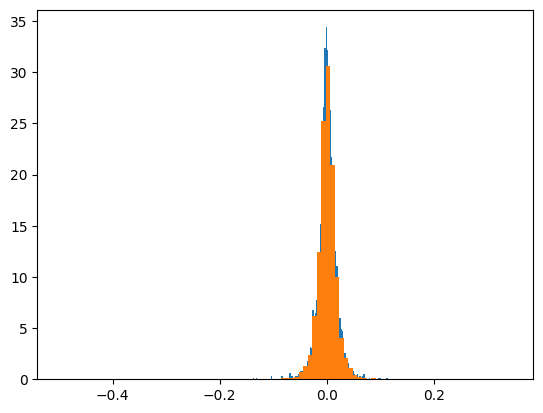

In [197]:
from scipy.stats import t

params = t.fit(pct_change)
df = params[0]
loc, scale=params[1], params[2]
plt.hist(pct_change,bins=100,density=True)
plt.hist(t.rvs(df=df,loc=loc,scale=scale,size=10000),density=True,bins=100)

plt.show()

In [213]:
sim =1000
length = len(data_test['Close'])
stock_pct = np.ones((length,sim))
for i in range(sim):
    simulated_values = t.rvs(df=df,loc=loc,scale=scale,size=length)
    stock_pct[:,i] = np.exp(np.cumsum(simulated_values))
stock_pct *=data['Close'][-1]
quantiles_90 = np.zeros((2,length))
quantiles_60 = np.zeros((2,length))
for i in range(1,length):
    quantiles_90[0,i] = np.quantile(stock_pct[i,:],0.1)
    quantiles_90[1,i] = np.quantile(stock_pct[i,:],0.9)
    quantiles_60[0,i] = np.quantile(stock_pct[i,:],0.4)
    quantiles_60[1,i] = np.quantile(stock_pct[i,:],0.6)
#means = pd.DataFrame(stock_pct,index=data_test.index)


In [205]:
print(means.iloc[-1])

0      163.182335
1      264.974125
2      174.217119
3      227.862536
4      174.434821
          ...    
995    178.172639
996    172.819953
997    180.529255
998    207.152129
999    396.855635
Name: 2023-04-28 00:00:00, Length: 1000, dtype: float64


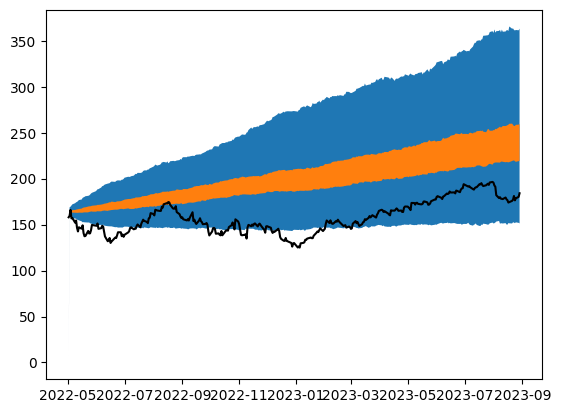

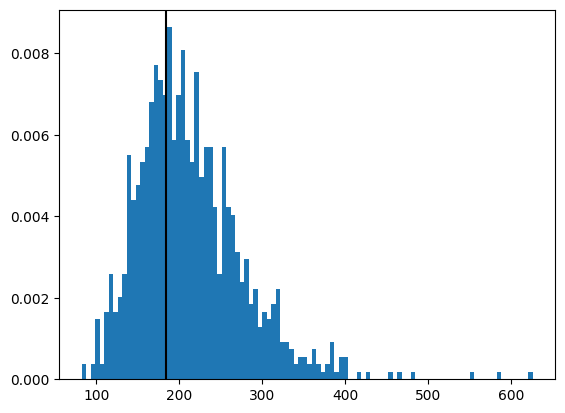

In [214]:

#plt.plot(means,alpha=0.1)
plt.plot(data_test['Close'],'k')
plt.fill_between(data_test['Close'].index,quantiles_90[0,:],quantiles_90[1,:],alpha=1)
plt.fill_between(data_test['Close'].index,quantiles_60[0,:],quantiles_60[1,:],alpha=1)
plt.show()

plt.hist(means.iloc[-1],bins=100,density=True)
plt.axvline(x=data_test['Close'][-1],color='k')
plt.show()

In [229]:
initial_portfolio = 1000
portfolio = 1000
number_of_stocks = 0
buys = {}
sells = {}
for i in range(0,len( data_test['Close'])):
    price = data_test['Close'][i]
    if price<=quantiles_90[0,i] and portfolio>0: 
        buys[i] = portfolio/price
        number_of_stocks+=portfolio/price
        portfolio-=round(number_of_stocks*price,2)
        
    if price>=quantiles_60[0,i] and number_of_stocks>0: 
        sells[i] = number_of_stocks
        portfolio+=round(number_of_stocks*price,2)
        number_of_stocks-=portfolio/price
        

print(portfolio+number_of_stocks*data_test['Close'][-1])

{1: 6.27037889885847, 3: 6.6403646847566575, 104: 8.020845271397727} {2: 6.27037889885847, 71: 6.640354635235365} 0.0
1476.7927213599887


In [3]:
import datetime as date_time
from scipy.stats import t
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import random
import sys, os
import time

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

class trading_sim():
    
    def __init__(self,stocks,weights,start,end,n_sim,recalc_freq,initial_portfolio,quantile_buy, quantile_sell, history_start, verbose):
        self.stocks = stocks
        self.weights = weights
        self.end = end
        self.start = start
        self.n_sim = n_sim
        self.recalc_freq = recalc_freq
        self.initial_portfolio = initial_portfolio
        self.date_format = "%Y-%m-%d"
        self.end_days, self.start_days =  date_time.datetime.strptime(self.end, self.date_format),  date_time.datetime.strptime(self.start, self.date_format)
        self.quantile_buy, self.quantile_sell = quantile_buy, quantile_sell
        self.transactions = {'buys':{},'sells':{}}
        self.portfolio_worth = {}
        self.buy_and_hold = {}
        self.history_start = history_start
        self.verbose = verbose
        
    def download_data(self,j):
        
        time_delta_history = date_time.timedelta(days=j*self.recalc_freq)
        end_history = self.start_days+time_delta_history
        if self.history_start==None: start_history = None
        else: start_history = end_history-date_time.timedelta(days=self.history_start*self.recalc_freq)
        start_test = self.start_days+date_time.timedelta(days=j*self.recalc_freq+1)
        time_delta_test = start_test+date_time.timedelta(days=self.recalc_freq)
        
        if time_delta_test>self.end_days: end_test = self.end_days
        else: end_test = time_delta_test
        
        history = yf.download(self.stocks, start=start_history, end=end_history)
        data_test = yf.download(self.stocks, start=start_test, end=end_test)
        if j==0: self.buy_and_hold_start = history['Close'][-1]
        return history, data_test
    
    def t_distribution(self,pct_change):
        
        params = t.fit(pct_change)
        df = params[0]
        loc, scale=params[1], params[2]
        
        return df, loc, scale
    
    def strategy(self,stock_pct,data_test,portfolio,number_of_stocks,buys, sells, plot):
        
        quantiles_sell = np.zeros(len(data_test['Close']))
        quantiles_buy = np.zeros(len(data_test['Close']))
            
        if plot==True: self.plot(stock_pct,data_test)
        for i in range(0,len(data_test['Close'])):
            quantiles_buy[i] = np.quantile(stock_pct[i,:],self.quantile_buy)
            quantiles_sell[i] = np.quantile(stock_pct[i,:],self.quantile_sell)
            
            price = data_test['Close'][i]
            if price<=quantiles_buy[i] and portfolio>0: 
                buys.append(str(data_test.index[i])+' bought: '+str(portfolio/price)+' at price '+str(round(price,2)))
                x = portfolio
                number_of_stocks+=round(x/price,2)
                portfolio-=x

            if price>=quantiles_sell[i] and number_of_stocks>0: 
                sells.append(str(data_test.index[i])+' sold: '+str(number_of_stocks)+' at price '+str(round(price,2)))
                x = number_of_stocks
                portfolio+=round(x*price,2)
                number_of_stocks-=x
                
                
        return portfolio, number_of_stocks, buys, sells
    
    def plot(self,stock_pct,data_test):
        quantiles_sell = np.zeros((2,len(data_test['Close'])))
        quantiles_buy = np.zeros((2,len(data_test['Close'])))
        for i in range(0,len(data_test['Close'])):
            quantiles_buy[0,i] = np.quantile(stock_pct[i,:],self.quantile_buy)
            quantiles_buy[1,i] = np.quantile(stock_pct[i,:],1-self.quantile_buy)
            quantiles_sell[0,i] = np.quantile(stock_pct[i,:],self.quantile_sell)
            quantiles_sell[1,i] = np.quantile(stock_pct[i,:],1-self.quantile_sell)
            
        plt.plot(data_test['Close'],'k')
        plt.fill_between(data_test['Close'].index,quantiles_buy[0,:],quantiles_buy[1,:],alpha=0.5,label=str(self.quantile_buy)+' '+'quantile')
        plt.fill_between(data_test['Close'].index,quantiles_sell[1,:],quantiles_sell[0,:],alpha=0.5,label=str(self.quantile_sell)+' '+'quantile')
        plt.legend()
        plt.show()
    
    def run_sim(self,plot=False):
        
        portfolio = self.initial_portfolio
        number_of_stocks = 0
        buys = []
        sells = []
        j = 0
        days_passed = 0#self.recalc_freq
        dt = (self.end_days - self.start_days).days
        while days_passed<dt:
            with HiddenPrints(): 
                data, data_test = self.download_data(j)
            pct_change = np.log(data['Close'].pct_change().dropna()+1)
            df, loc, scale = self.t_distribution(pct_change)
            
            simulated_values = t.rvs(df=df,loc=loc,scale=scale,size=(self.recalc_freq,self.n_sim))
            stock_pct = np.exp(np.cumsum(simulated_values,axis=0))
            
            stock_pct *=data_test['Close'][0]            
            portfolio, number_of_stocks, buys, sells = self.strategy(stock_pct,data_test,portfolio,number_of_stocks,buys, sells, plot)
            portfolio_worth = portfolio+number_of_stocks*data_test['Close'][-1]
            
            if self.verbose: print(str(data_test.index[-1])+' portfolio worth: '+str(round(portfolio_worth,2))+' (number of stocks= '+str(number_of_stocks)+')')
            self.portfolio_worth[str(data_test.index[-1])] = portfolio_worth
            self.buy_and_hold[str(data_test.index[-1])] = data_test['Close'][-1]*self.initial_portfolio/self.buy_and_hold_start
            days_passed+=self.recalc_freq 
            j+=1
        self.transactions['buys'], self.transactions['sells'] = buys, sells 
        print(str(data_test.index[-1])+' portfolio worth: '+str(round(portfolio_worth,2))+' (number of stocks= '+str(number_of_stocks)+')')
        print('Buy and hold portfolio worth: '+str(round(self.initial_portfolio/self.buy_and_hold_start*data_test['Close'][-1],2)))
        
        return portfolio, number_of_stocks

In [4]:
stocks = ['AAPL']
weights = np.ones(len(stocks))*(1/len(stocks))

end = '2023-8-30'
start = '2015-4-30'
n = 400
results = {}
results['worth'] = 0
best_params = {}
runs = {}
runs['recalc_freq'], runs['quantile_sell'], runs['quantile_buy'], runs['history_start'], runs['worth'] = \
np.ones(n), np.ones(n), np.ones(n), np.ones(n), -np.ones(n)

for i in range(n):

    recalc_freq = random.randint(50,200)
    quantile_sell = round(random.uniform(0.8,0.95),2)
    quantile_buy = round(random.uniform(0.05,0.5),2)
    history_start = random.randint(1,5)
    runs['recalc_freq'][i] = recalc_freq
    runs['quantile_buy'][i] = quantile_buy
    runs['quantile_sell'][i] = quantile_sell
    runs['history_start'][i] = history_start
    try:
        trading_simulation = trading_sim(stocks,weights, start,end,n_sim=1000, recalc_freq=recalc_freq, initial_portfolio=1000,
                                         quantile_buy=quantile_buy, quantile_sell=quantile_sell, history_start=history_start, verbose=False) 
        results['portfolio'], results['number_of_stocks'] = trading_simulation.run_sim(plot=False)

        runs['worth'][i] = round(list(trading_simulation.portfolio_worth.values())[-1],2)
    except:
        print(recalc_freq,quantile_buy,quantile_sell,history_start)
    if list(trading_simulation.portfolio_worth.values())[-1]>results['worth']: 
        results['worth']= round(list(trading_simulation.portfolio_worth.values())[-1],2)
        best_params['recalc_freq'] = recalc_freq
        best_params['quantile_buy'] = quantile_buy
        best_params['quantile_sell'] = quantile_sell
        best_params['history_start'] = history_start
        best_sim = trading_simulation
    
    
print(results,best_params)

2023-08-29 00:00:00 portfolio worth: 3442.08 (number of stocks= 0.0)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 2115.54 (number of stocks= 11.49)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 5634.07 (number of stocks= 30.6)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 6893.45 (number of stocks= 37.44)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 3988.04 (number of stocks= 21.66)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 5941.55 (number of stocks= 32.27)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 4239.48 (number of stocks= 0.0)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 6409.22 (number of stocks= 34.81)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 4669.09 (number of stocks= 0.0)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfo

/opt/conda/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2750: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


95 0.42 0.93 3
2023-08-29 00:00:00 portfolio worth: 6492.07 (number of stocks= 35.26)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 3619.8 (number of stocks= 19.66)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 6615.43 (number of stocks= 35.93)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 6348.46 (number of stocks= 34.48)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 2360.42 (number of stocks= 12.82)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 5098.28 (number of stocks= 27.69)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 3584.82 (number of stocks= 19.47)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 3316.0 (number of stocks= 18.01)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 5866.06 (number of stocks= 31.86)
Buy and hold portfolio worth: 5725.12
2023-0

In [110]:
runs

{'recalc_freq': array([ 91., 181., 175., 184.,  39.,  93.,  58., 176.,  71., 171.,  25.,
         51.,  21., 193.,  84., 188.,  97., 137., 164., 151., 145., 141.,
        114.,  61., 133., 106., 179.,  43.,  74., 193., 120., 196., 187.,
         53., 153.,  28., 135.,  89., 123., 122.,  54.,  20.,  50.,  78.,
        161., 153.,  40., 174.,  22., 112.,  54.,  45., 102.,  37., 187.,
        159., 133.,  60., 101.,  43.,  45., 170., 166., 184.,  34., 172.,
         38.,  72., 117.,  99., 189., 183., 185., 107.,  35., 155., 132.,
        195., 125., 182., 144., 143.,  94.,  78.,  42., 130., 148.,  28.,
        182., 192., 183.,  64.,  74.,  47., 196.,  64.,  45.,  36.,  37.,
         56.]),
 'quantile_sell': array([0.62, 0.55, 0.52, 0.84, 0.57, 0.7 , 0.66, 0.89, 0.5 , 0.74, 0.77,
        0.6 , 0.87, 0.5 , 0.51, 0.51, 0.75, 0.67, 0.9 , 0.86, 0.63, 0.56,
        0.67, 0.85, 0.7 , 0.93, 0.52, 0.89, 0.61, 0.57, 0.65, 0.8 , 0.76,
        0.79, 0.85, 0.91, 0.79, 0.8 , 0.55, 0.8 , 0.82, 0.73, 0.

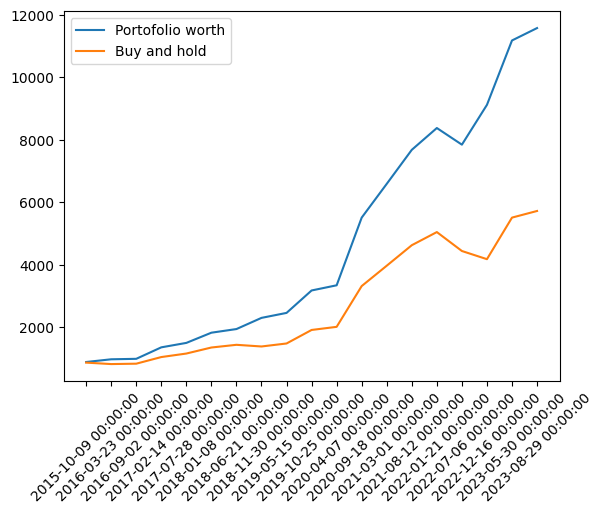

[*********************100%%**********************]  1 of 1 completed


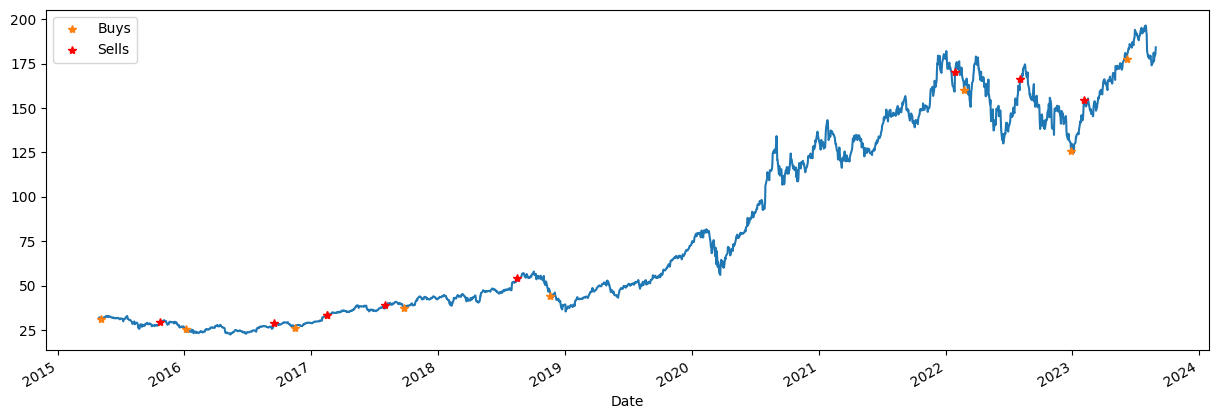

0.2175


In [9]:
portfolio_worth = pd.DataFrame(best_sim.portfolio_worth.values(),index=best_sim.portfolio_worth.keys())
buy_and_hold = pd.DataFrame(best_sim.buy_and_hold.values(),index=best_sim.buy_and_hold.keys())

plt.plot(portfolio_worth,label='Portofolio worth')
plt.plot(buy_and_hold,label='Buy and hold')
plt.legend()
plt.xticks(rotation=45)
plt.show()

buy_days = [d.split()[0] for d in best_sim.transactions['buys']]
sell_days = [d.split()[0] for d in best_sim.transactions['sells']]
history = yf.download(stocks, start=start, end=end)
buys = pd.Series(history['Close'].loc[buy_days])
sells = history['Close'].loc[sell_days]

plt.figure(figsize=(15,5))
plt.plot(history['Close'])
buys.plot(x='index',y='Close',marker='*',ls='none',label='Buys')
sells.plot(x='index',y='Close',marker='*',ls='none',color='r',label='Sells')
plt.legend()
plt.show()

print(len(runs['worth'][runs['worth']>=5725.12])/len(runs['worth']))

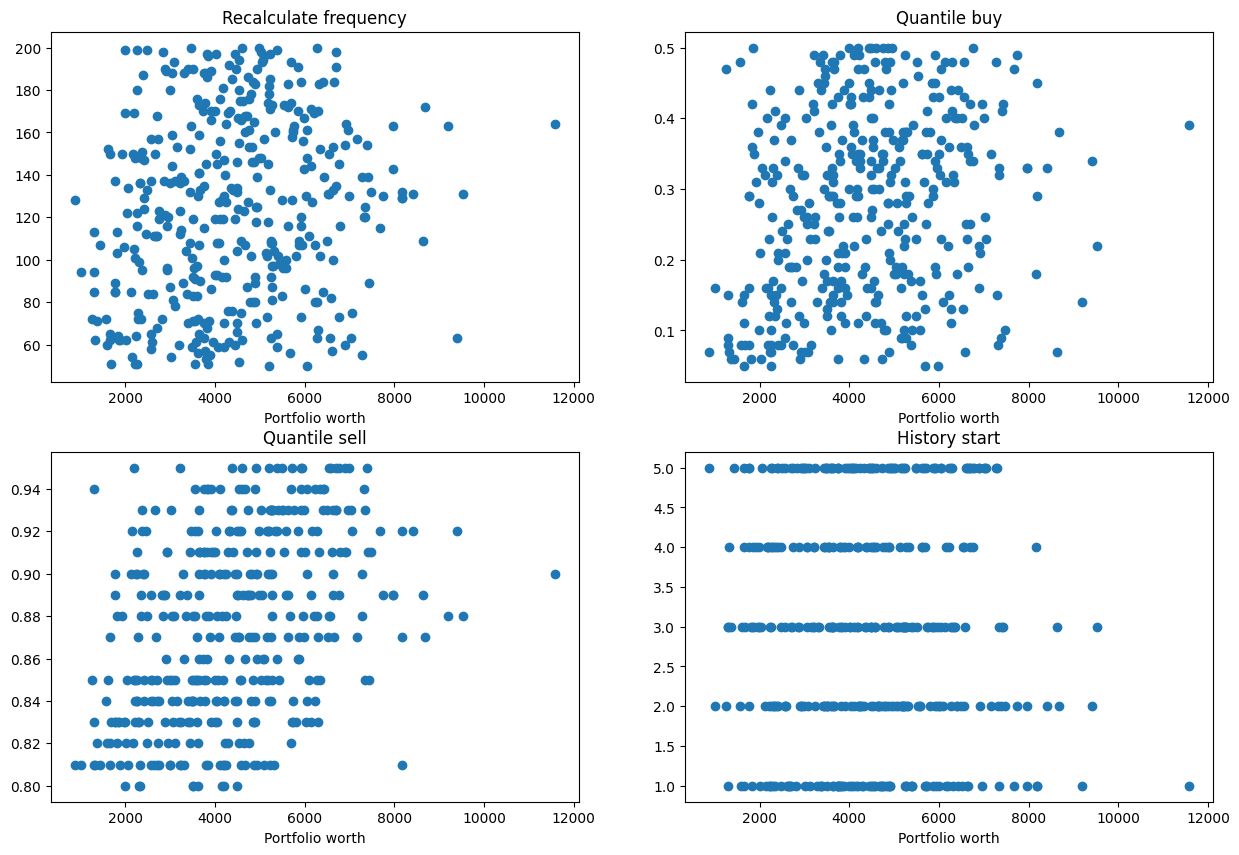

In [6]:

fig, axs = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
axs[0, 0].scatter(runs['worth'][runs['worth']>=0], runs['recalc_freq'][runs['worth']>=0])
axs[0, 0].set_title('Recalculate frequency')
axs[0, 1].scatter(runs['worth'][runs['worth']>=0], runs['quantile_buy'][runs['worth']>=0])
axs[0, 1].set_title('Quantile buy')
axs[1, 0].scatter(runs['worth'][runs['worth']>=0], runs['quantile_sell'][runs['worth']>=0])
axs[1, 0].set_title('Quantile sell')
axs[1, 1].scatter(runs['worth'][runs['worth']>=0], runs['history_start'][runs['worth']>=0])
axs[1, 1].set_title('History start')

for ax in axs.flat:
    ax.set(xlabel='Portfolio worth')



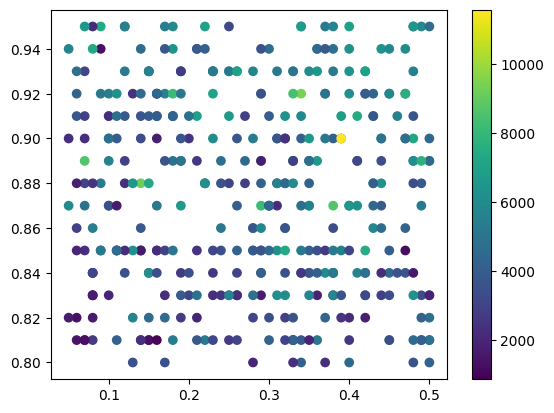

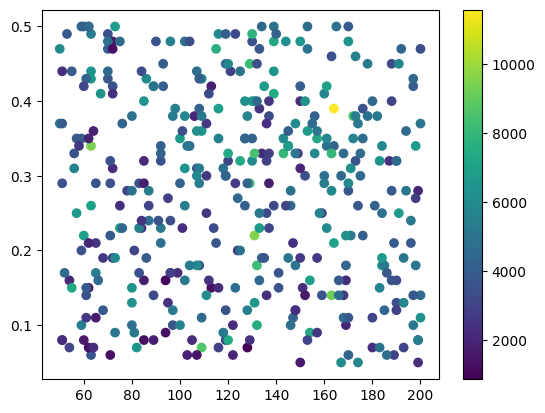

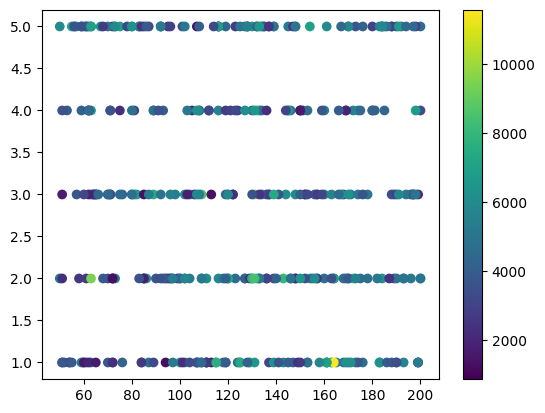

In [7]:
plt.scatter(runs['quantile_buy'][runs['worth']>=0],runs['quantile_sell'][runs['worth']>=0],c=runs['worth'][runs['worth']>=0])
plt.colorbar()
plt.show()
plt.scatter(runs['recalc_freq'][runs['worth']>=0],runs['quantile_buy'][runs['worth']>=0],c=runs['worth'][runs['worth']>=0])
plt.colorbar()
plt.show()
plt.scatter(runs['recalc_freq'][runs['worth']>=0],runs['history_start'][runs['worth']>=0],c=runs['worth'][runs['worth']>=0])
plt.colorbar()
plt.show()

In [10]:
stocks = ['AAPL']
weights = np.ones(len(stocks))*(1/len(stocks))

end = '2023-8-30'
start = '2015-4-30'
n = 100
results = {}
results['worth'] = 0
best_params = {}
runs = {}
runs['recalc_freq'], runs['quantile_sell'], runs['quantile_buy'], runs['history_start'], runs['worth'] = \
np.ones(n), np.ones(n), np.ones(n), np.ones(n), -np.ones(n)
for i in range(n):
    recalc_freq = random.randint(100,150)
    quantile_sell = round(random.uniform(0.8,0.95),2)
    quantile_buy = round(random.uniform(0.2,0.4),2)
    history_start = random.randint(1,5)
    runs['recalc_freq'][i] = recalc_freq
    runs['quantile_buy'][i] = quantile_buy
    runs['quantile_sell'][i] = quantile_sell
    runs['history_start'][i] = history_start
    try:
        trading_simulation = trading_sim(stocks,weights, start,end,n_sim=5000, recalc_freq=recalc_freq, initial_portfolio=1000,
                                         quantile_buy=quantile_buy, quantile_sell=quantile_sell, history_start=history_start, verbose=False) 
        results['portfolio'], results['number_of_stocks'] = trading_simulation.run_sim(plot=False)

        runs['worth'][i] = round(list(trading_simulation.portfolio_worth.values())[-1],2)
    except:
        print(recalc_freq,quantile_buy,quantile_sell,history_start)
    if list(trading_simulation.portfolio_worth.values())[-1]>results['worth']: 
        results['worth']= round(list(trading_simulation.portfolio_worth.values())[-1],2)
        best_params['recalc_freq'] = recalc_freq
        best_params['quantile_buy'] = quantile_buy
        best_params['quantile_sell'] = quantile_sell
        best_params['history_start'] = history_start
        best_sim = trading_simulation

print(results,best_params)

2023-08-29 00:00:00 portfolio worth: 1566.86 (number of stocks= 8.51)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 6271.13 (number of stocks= 34.06)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 7009.45 (number of stocks= 38.07)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 4525.3 (number of stocks= 0.0)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 6593.34 (number of stocks= 35.81)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 3196.32 (number of stocks= 17.36)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 4682.17 (number of stocks= 25.43)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 2972.77 (number of stocks= 0.0)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portfolio worth: 4091.15 (number of stocks= 22.22)
Buy and hold portfolio worth: 5725.12
2023-08-29 00:00:00 portf

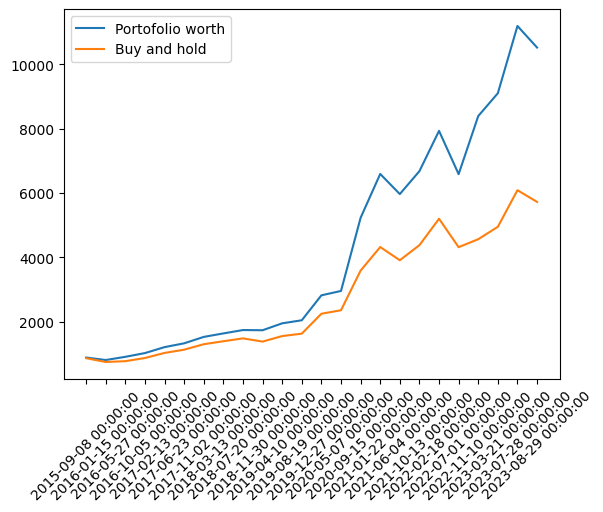

[*********************100%%**********************]  1 of 1 completed


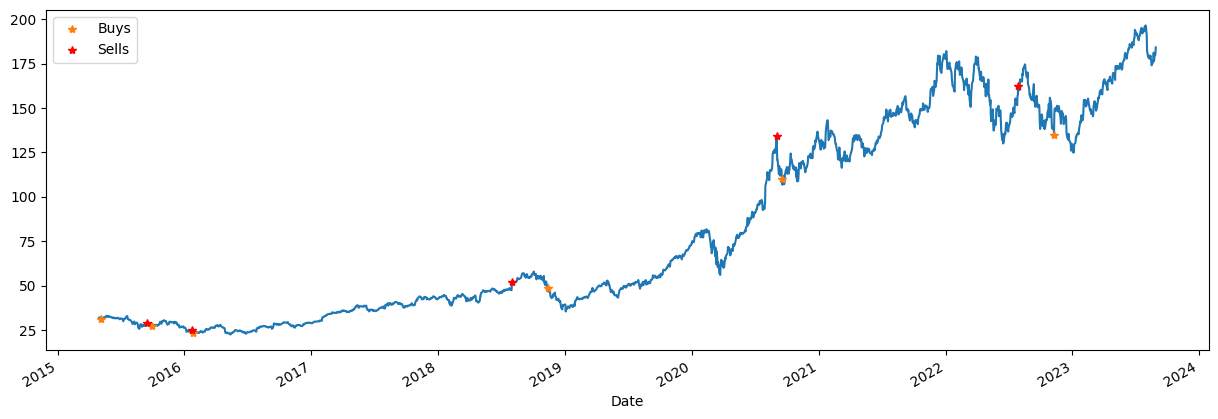

0.27


In [14]:
portfolio_worth = pd.DataFrame(best_sim.portfolio_worth.values(),index=best_sim.portfolio_worth.keys())
buy_and_hold = pd.DataFrame(best_sim.buy_and_hold.values(),index=best_sim.buy_and_hold.keys())

plt.plot(portfolio_worth,label='Portofolio worth')
plt.plot(buy_and_hold,label='Buy and hold')
plt.legend()
plt.xticks(rotation=45)
plt.show()

buy_days = [d.split()[0] for d in best_sim.transactions['buys']]
sell_days = [d.split()[0] for d in best_sim.transactions['sells']]
history = yf.download(stocks, start=start, end=end)
buys = pd.Series(history['Close'].loc[buy_days])
sells = history['Close'].loc[sell_days]

plt.figure(figsize=(15,5))
plt.plot(history['Close'])
buys.plot(x='index',y='Close',marker='*',ls='none',label='Buys')
sells.plot(x='index',y='Close',marker='*',ls='none',color='r',label='Sells')
plt.legend()
plt.show()
print(len(runs['worth'][runs['worth']>=5725.12])/len(runs['worth']))

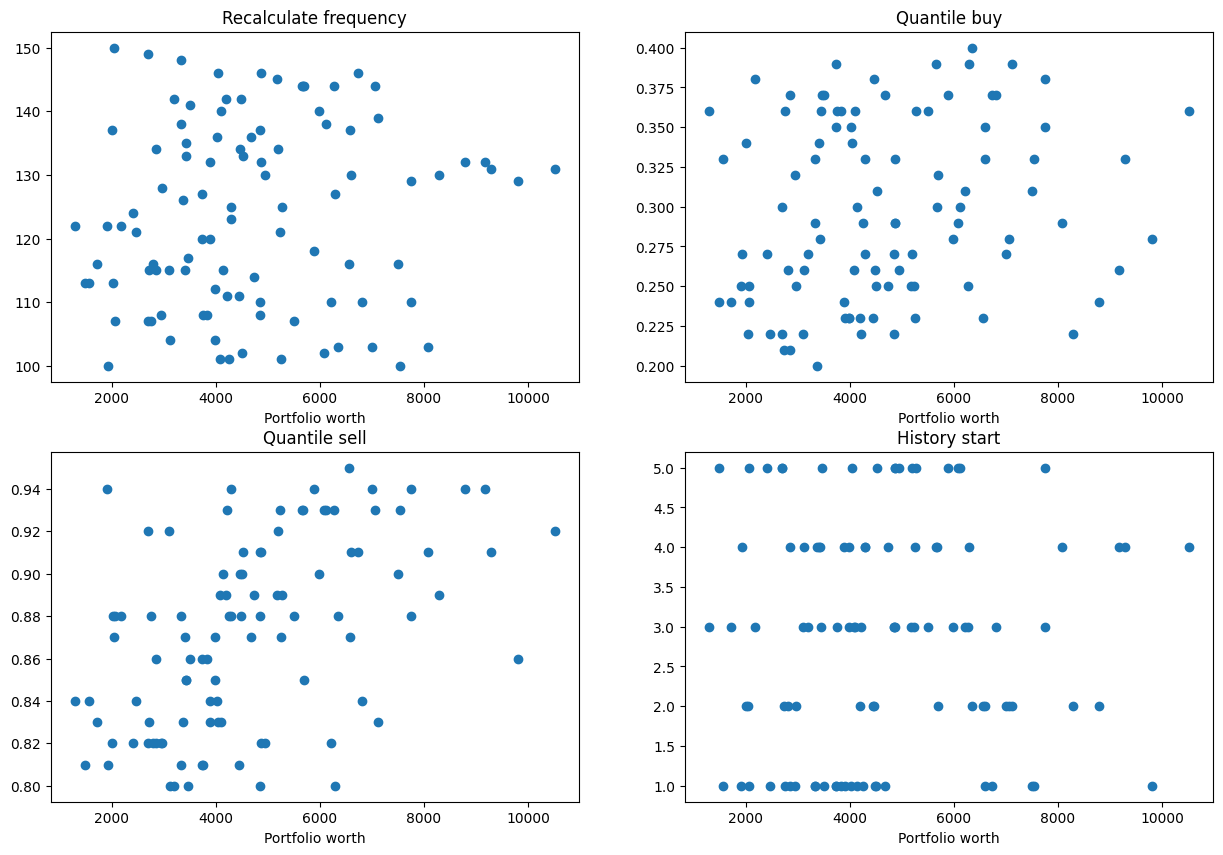

In [12]:

fig, axs = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
axs[0, 0].scatter(runs['worth'][runs['worth']>=0], runs['recalc_freq'][runs['worth']>=0])
axs[0, 0].set_title('Recalculate frequency')
axs[0, 1].scatter(runs['worth'][runs['worth']>=0], runs['quantile_buy'][runs['worth']>=0])
axs[0, 1].set_title('Quantile buy')
axs[1, 0].scatter(runs['worth'][runs['worth']>=0], runs['quantile_sell'][runs['worth']>=0])
axs[1, 0].set_title('Quantile sell')
axs[1, 1].scatter(runs['worth'][runs['worth']>=0], runs['history_start'][runs['worth']>=0])
axs[1, 1].set_title('History start')

for ax in axs.flat:
    ax.set(xlabel='Portfolio worth')


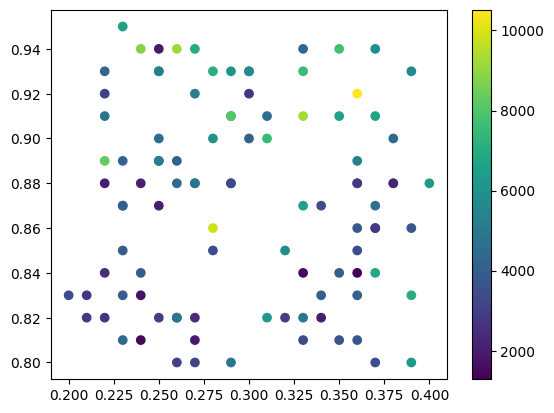

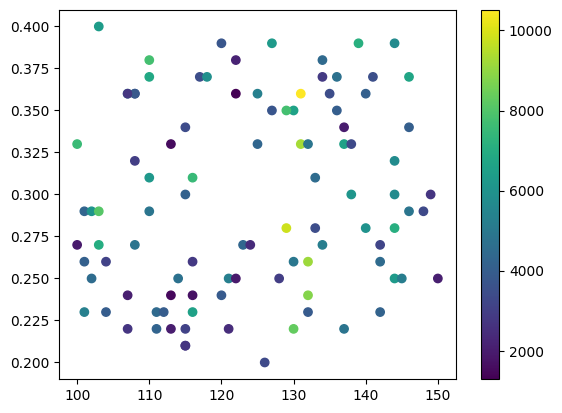

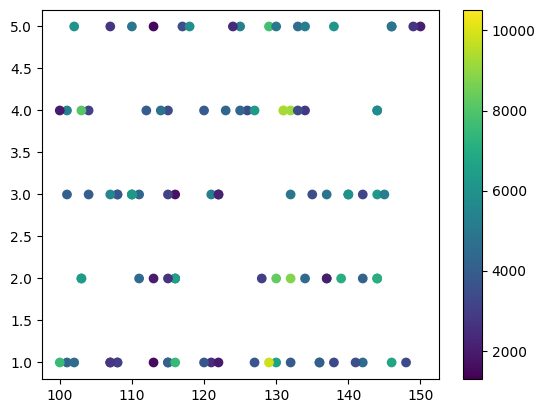

In [13]:
plt.scatter(runs['quantile_buy'][runs['worth']>=0],runs['quantile_sell'][runs['worth']>=0],c=runs['worth'][runs['worth']>=0])
plt.colorbar()
plt.show()
plt.scatter(runs['recalc_freq'][runs['worth']>=0],runs['quantile_buy'][runs['worth']>=0],c=runs['worth'][runs['worth']>=0])
plt.colorbar()
plt.show()
plt.scatter(runs['recalc_freq'][runs['worth']>=0],runs['history_start'][runs['worth']>=0],c=runs['worth'][runs['worth']>=0])
plt.colorbar()
plt.show()